In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from pmdarima.utils import tsdisplay, plot_acf, plot_pacf
from pmdarima import auto_arima

from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv('../data/las-vegas_nv.csv', parse_dates=True, index_col='date').drop(columns=['city', 'state'])
df.sort_index(inplace=True)
df

,humidity (%),precipitation (in),avg_temp (°F),pressure (hPa),wind (mph)
date,,,,,
2021-01-01,57,0.00,47,1016,21
2021-01-02,31,0.00,46,1021,18
2021-01-03,36,0.00,45,1022,6
2021-01-04,36,0.00,47,1021,7
2021-01-05,32,0.00,50,1017,14
...,...,...,...,...,...
2024-03-28,22,0.00,68,1010,29
2024-03-29,17,0.00,63,1008,24
2024-03-30,48,5.30,54,1004,20


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1187 entries, 2021-01-01 to 2024-04-01
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   humidity (%)        1187 non-null   int64  
 1   precipitation (in)  1187 non-null   float64
 2   avg_temp (°F)       1187 non-null   int64  
 3   pressure (hPa)      1187 non-null   int64  
 4   wind (mph)          1187 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 55.6 KB


In [37]:
print(f"Max avg temp between 2021 and 2024 was {round(max(df.loc['2021-01-01':'2024-01-01', 'avg_temp (°F)']), 2)}°F")

Max avg temp between 2021 and 2024 was 105°F


In [38]:
print(f"Avg temp between 2021 and 2024 was {round(df.loc['2021-01-01':'2024-01-01', 'avg_temp (°F)'].mean(), 2)}°F")

Avg temp between 2021 and 2024 was 70.8°F


In [39]:
df.corr()

,humidity (%),precipitation (in),avg_temp (°F),pressure (hPa),wind (mph)
humidity (%),1.000000,0.355072,-0.461786,0.213010,0.006259
precipitation (in),0.355072,1.000000,-0.062982,-0.077631,0.131162
avg_temp (°F),-0.461786,-0.062982,1.000000,-0.513027,0.047056
pressure (hPa),0.213010,-0.077631,-0.513027,1.000000,-0.355062
wind (mph),0.006259,0.131162,0.047056,-0.355062,1.000000


We can notice that humidity and pressure has a strong negative correlation with temperature and as humidity increases, precipitation also increases slightly which is as expected.


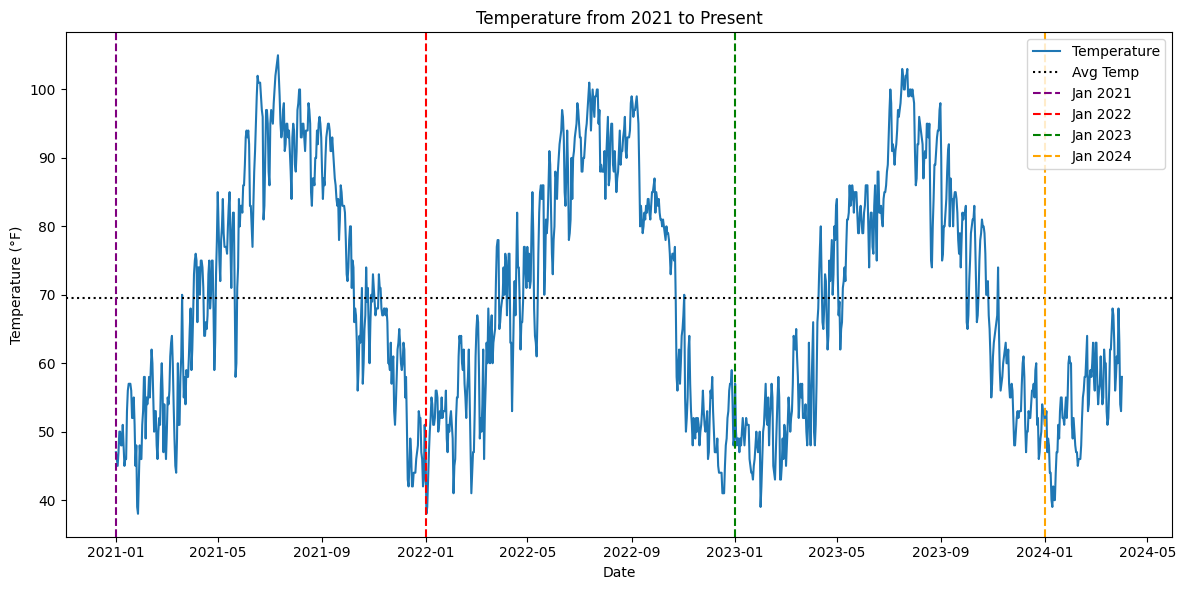

In [40]:
plt.figure(figsize=(12, 6))
sns.lineplot(df['avg_temp (°F)'], label='Temperature')
plt.axhline(df['avg_temp (°F)'].mean(), color='black', linestyle=':', label='Avg Temp')
plt.axvline(pd.to_datetime('2021-01-01'), color='purple', linestyle='--', label='Jan 2021')
plt.axvline(pd.to_datetime('2022-01-01'), color='red', linestyle='--', label='Jan 2022')
plt.axvline(pd.to_datetime('2023-01-01'), color='green', linestyle='--', label='Jan 2023')
plt.axvline(pd.to_datetime('2024-01-01'), color='orange', linestyle='--', label='Jan 2024')
plt.title('Temperature from 2021 to Present')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

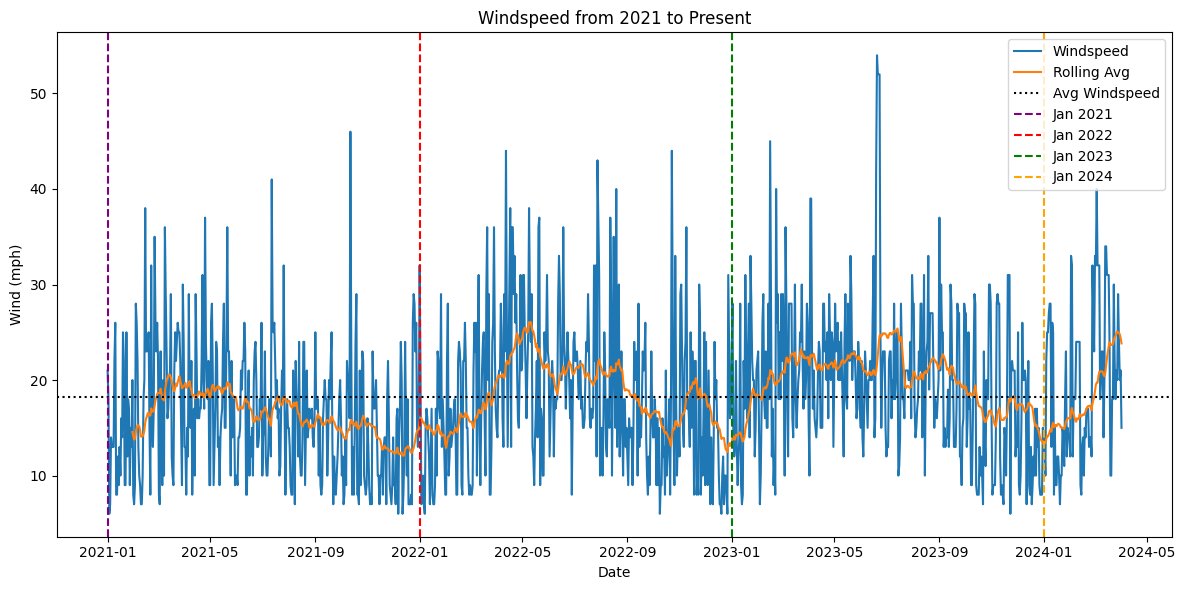

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(df['wind (mph)'], label='Windspeed')
sns.lineplot(df["wind (mph)"].rolling(window=30).mean(), label='Rolling Avg')
plt.axhline(df['wind (mph)'].mean(), color='black', linestyle=':', label='Avg Windspeed')
plt.axvline(pd.to_datetime('2021-01-01'), color='purple', linestyle='--', label='Jan 2021')
plt.axvline(pd.to_datetime('2022-01-01'), color='red', linestyle='--', label='Jan 2022')
plt.axvline(pd.to_datetime('2023-01-01'), color='green', linestyle='--', label='Jan 2023')
plt.axvline(pd.to_datetime('2024-01-01'), color='orange', linestyle='--', label='Jan 2024')
plt.title('Windspeed from 2021 to Present')
plt.ylabel('Wind (mph)')
plt.xlabel('Date')
plt.legend(loc= 'upper right')
plt.tight_layout()

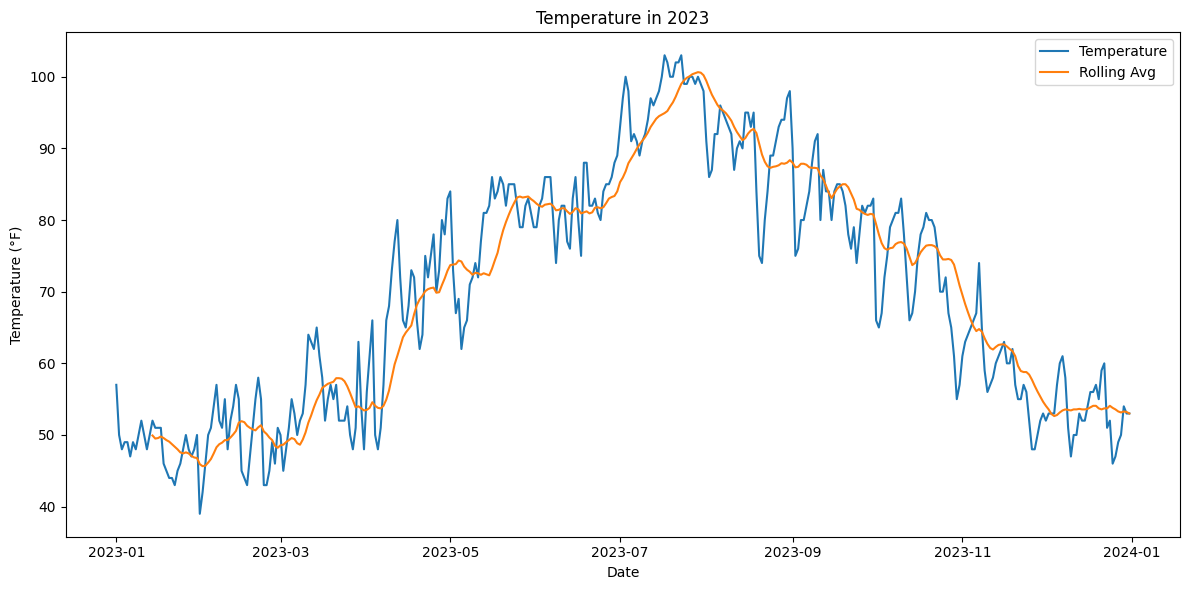

In [42]:
plt.figure(figsize=(12, 6))
sns.lineplot(df.loc['2023', 'avg_temp (°F)'], label='Temperature')
sns.lineplot(df.loc["2023", "avg_temp (°F)"].rolling(window=14).mean(), label='Rolling Avg')
plt.title('Temperature in 2023')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

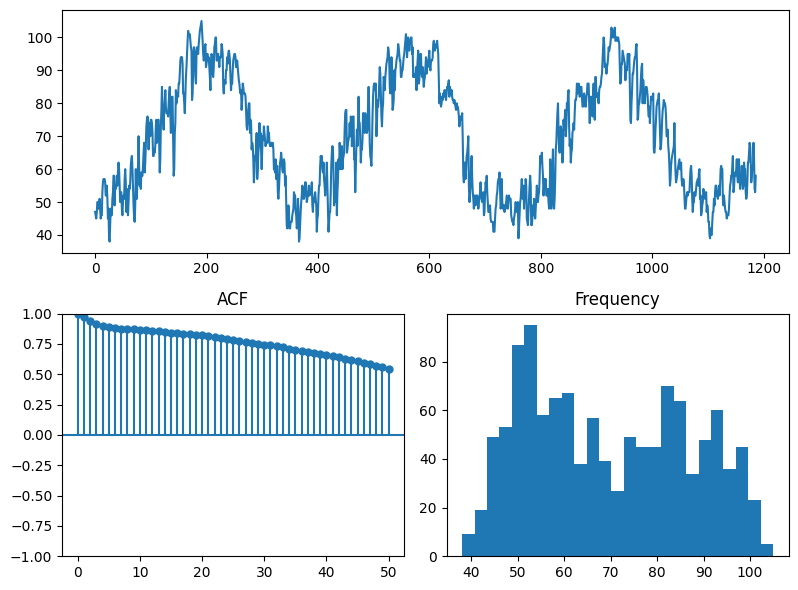

In [43]:
tsdisplay(df['avg_temp (°F)'])

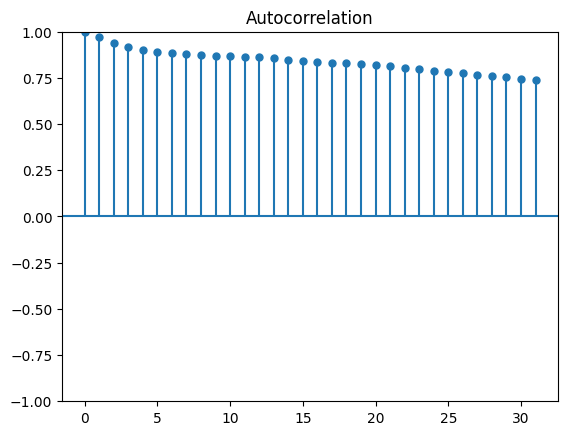

In [44]:
plot_acf(df['avg_temp (°F)'])

There is a strong positive autocorrelation indicating a strong seasonality trend in the data, meaning the past values strongly influence future values.


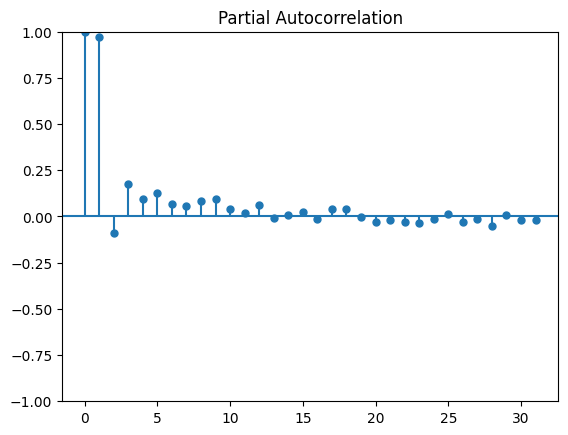

In [45]:
plot_pacf(df['avg_temp (°F)'])

There is no significant lag spikes indicating a weak partial autocorrelation meaning there is no important predictions.


---

<h2 align='center'>ARIMA</h2>


In [66]:
train = df['avg_temp (°F)']

model = auto_arima(train, seasonal=True, suppress_warnings=True)

best_order = model.order

print("Best ARIMA Order:", best_order)

Best ARIMA Order: (2, 1, 1)


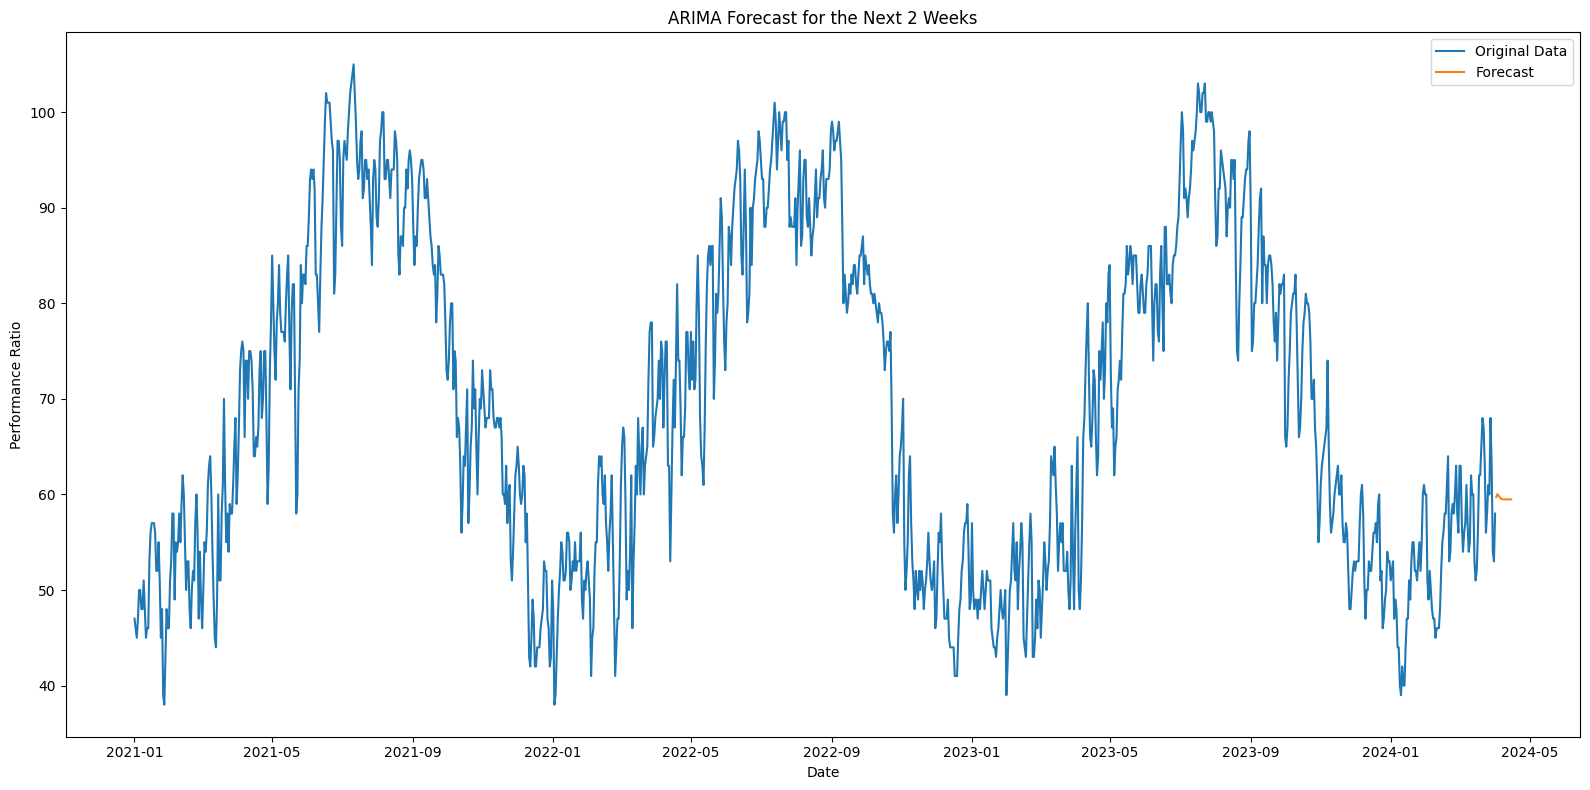

In [67]:
train_val = train.values

model = ARIMA(train_val, order=best_order)
model_fit = model.fit()

forecast_horizon = 14
y_pred = model_fit.predict(start=len(train_val), end=len(train_val) + forecast_horizon - 1, typ='levels')

forecast_dates = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

plt.figure(figsize=(16, 8))
plt.plot(train.index, train, label='Original Data')
plt.plot(forecast_dates, y_pred, label='Forecast')
plt.title('ARIMA Forecast for the Next 2 Weeks')
plt.xlabel('Date')
plt.ylabel('Performance Ratio')
plt.legend()
plt.tight_layout()

In [69]:
y = df['avg_temp (°F)'][-forecast_horizon:]

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 24.070536664207655


In [71]:
predicted_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Temp': y_pred.flatten()})
predicted_df.set_index('Date', inplace=True)
predicted_df

,Predicted_Temp
Date,
2024-04-02,59.730869
2024-04-03,60.034037
2024-04-04,59.890097
2024-04-05,59.699212
2024-04-06,59.571884
2024-04-07,59.508812
2024-04-08,59.485121
2024-04-09,59.479735
2024-04-10,59.480666


---

<h2 align='center'>Prophet</h2>


22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing


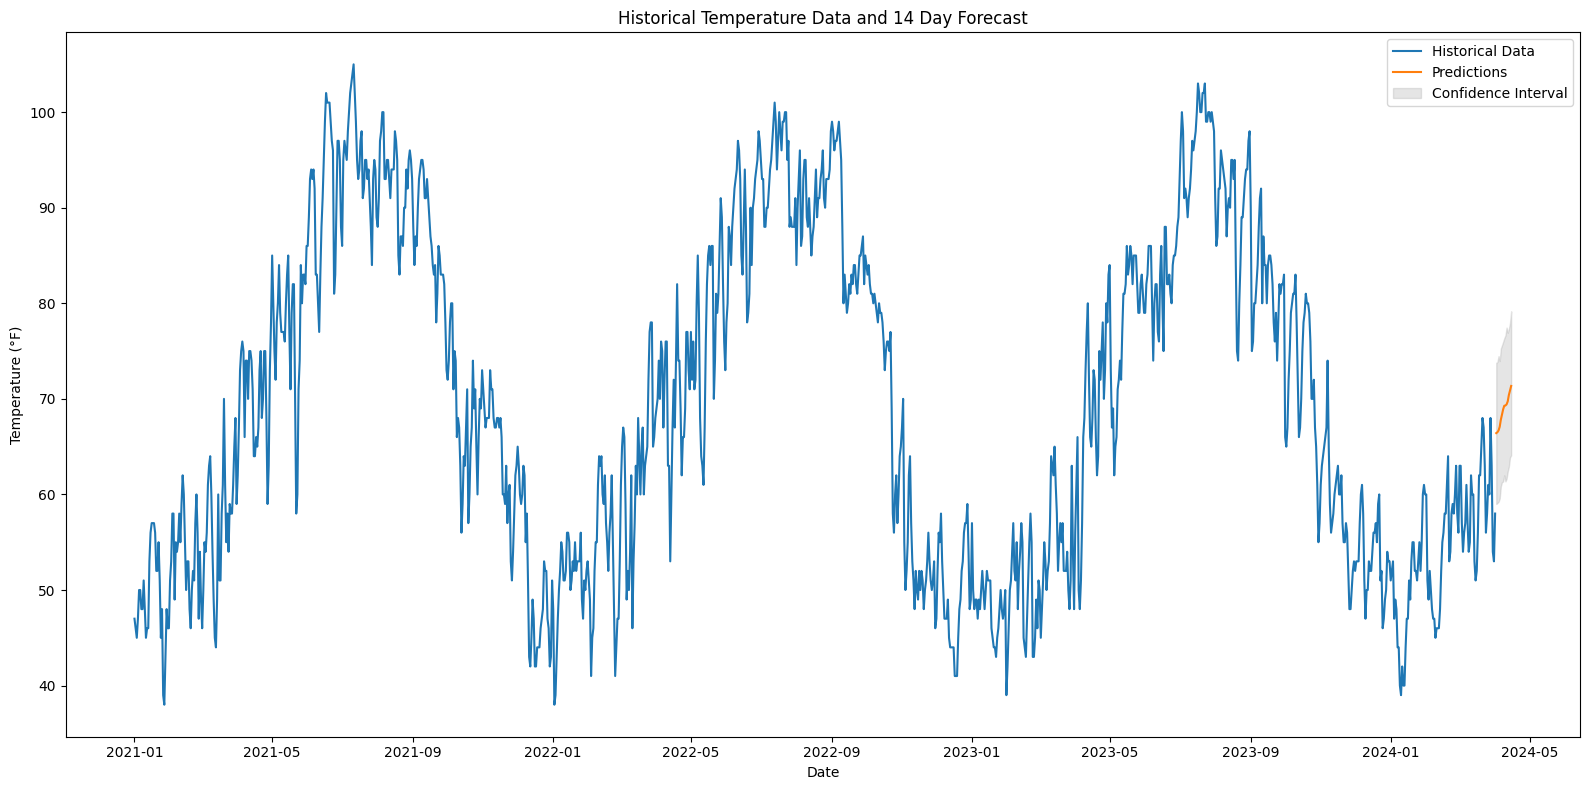

In [135]:
ph_df = df[['avg_temp (°F)']].reset_index()
ph_df.columns = ['ds', 'y']

model = Prophet()
model.fit(ph_df)

periods = 14

future = model.make_future_dataframe(periods=periods, freq='D')
forecast = model.predict(future)

plt.figure(figsize=(16, 8))
plt.plot(ph_df['ds'], ph_df['y'], label='Historical Data')
plt.plot(forecast['ds'][-periods:], forecast['yhat'][-periods:], label='Predictions')
plt.fill_between(forecast['ds'][-periods:], forecast['yhat_lower'][-periods:], forecast['yhat_upper'][-periods:], color='gray', alpha=0.2, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Historical Temperature Data and 14 Day Forecast')
plt.legend()
plt.tight_layout()

In [136]:
y = ph_df['y'][-periods:]
yhat_pred = forecast['yhat'][-periods:]

mse = mean_squared_error(y, yhat_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 91.98557275850533


In [137]:
predicted_dates = forecast['ds'][-periods:]
predicted_values = forecast['yhat'][-periods:]

predicted_df = pd.DataFrame({'Date': predicted_dates, 'predicted_temp': predicted_values})
predicted_df.set_index('Date', inplace=True)
predicted_df

,predicted_temp
Date,
2024-04-02,66.415957
2024-04-03,66.507655
2024-04-04,66.691252
2024-04-05,67.075726
2024-04-06,67.818139
2024-04-07,68.356360
2024-04-08,68.901909
2024-04-09,69.280640
2024-04-10,69.305807


In [138]:
predicted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:]

predicted_values.rename(columns={'ds': 'Date', 'yhat':'predicted_temp', 'yhat_lower':'predicted_temp_lower', 'yhat_upper':'predicted_temp_upper'}, inplace=True)

predicted_values.set_index('Date', inplace=True)
predicted_values

,predicted_temp,predicted_temp_lower,predicted_temp_upper
Date,,,
2024-04-02,66.415957,59.005991,73.780678
2024-04-03,66.507655,59.102916,73.851233
2024-04-04,66.691252,59.225303,74.471951
2024-04-05,67.075726,59.563343,73.963093
2024-04-06,67.818139,60.845551,75.270973
2024-04-07,68.356360,61.294969,75.600671
2024-04-08,68.901909,61.342111,75.969572
2024-04-09,69.280640,61.999068,76.346981
2024-04-10,69.305807,61.363439,76.638040


---

<h2 align='center'>XGBRegressor</h2>


Mean Squared Error: 320.886104858


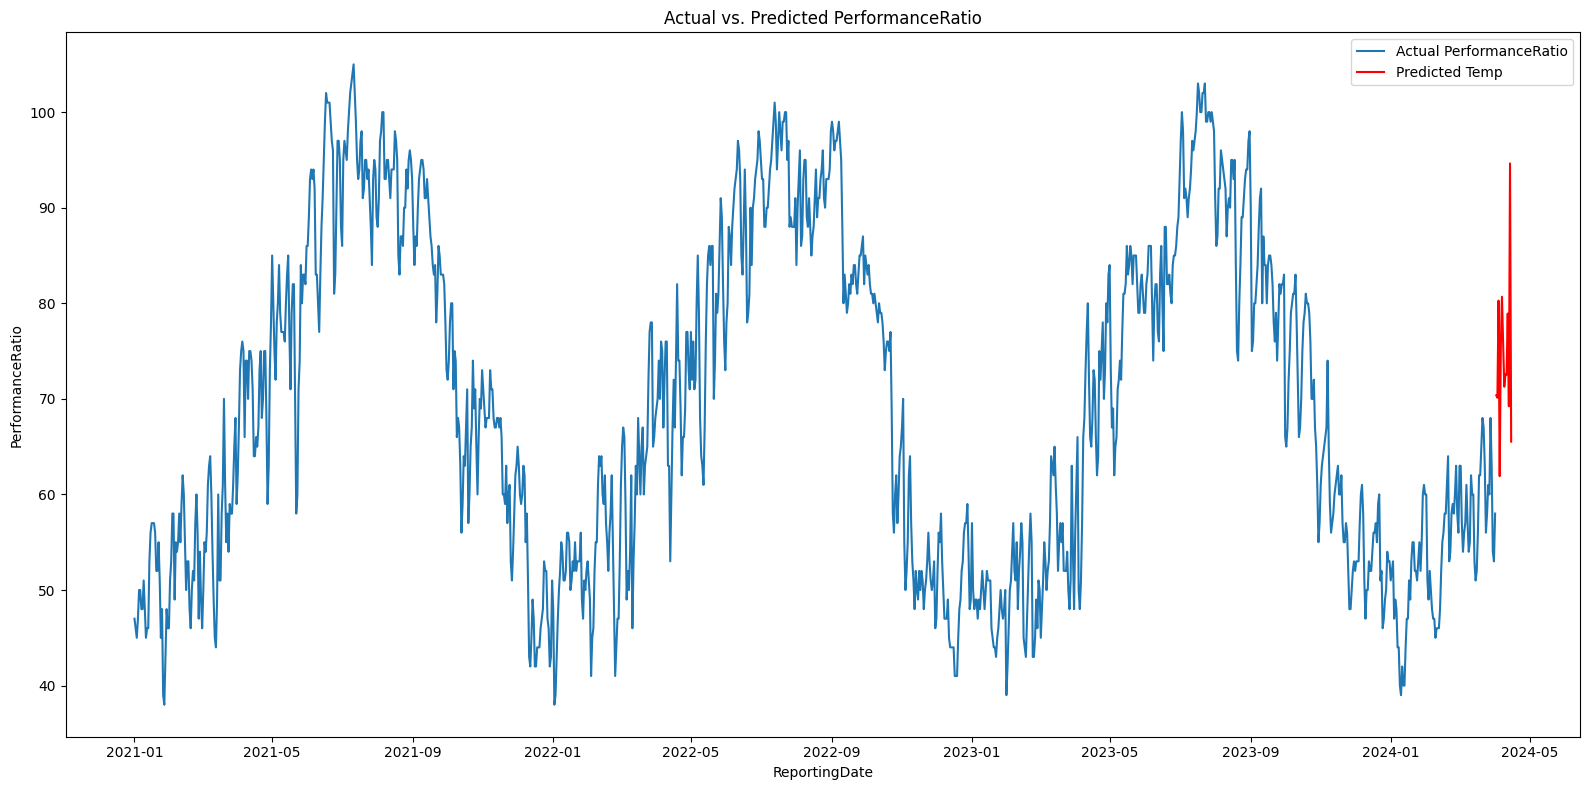

In [73]:
X = df.index.values.astype(int).reshape(-1, 1)
y = df['avg_temp (°F)']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

# Predicting for the next 2 weeks starting from the day after the last day in the dataset
time = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
predictions_df = pd.DataFrame(index=time, columns=['Predicted_Temp'])
predictions_df.index.name = 'Date'
predictions_df['Predicted_Temp'] = model.predict(predictions_df.index.values.astype(int).reshape(-1, 1))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['avg_temp (°F)'], label='Actual PerformanceRatio')
plt.plot(predictions_df.index, predictions_df['Predicted_Temp'], color='r', label='Predicted Temp')
plt.xlabel('ReportingDate')
plt.ylabel('PerformanceRatio')
plt.title('Actual vs. Predicted PerformanceRatio')
plt.legend()
plt.tight_layout()